In [1]:
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb

from IPython.display import display

# 正解率
from sklearn.metrics import accuracy_score

# 適合率
from sklearn.metrics import precision_score

# 再現率
from sklearn.metrics import recall_score

# f1_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

# DataFrameの表示数を変更
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(3))
display(train.tail(3))
display(train.shape)
display(train.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
847,50,Male,0.826785,0.138898,230.340081,40.495102,49.620857,7.529840,3.724408,0.987033,1
848,32,Female,0.761972,0.137969,214.170393,18.048321,54.447774,5.944855,3.150978,1.220787,0
849,64,Male,0.762713,0.218435,214.720510,15.885571,24.789606,6.768439,3.686097,1.309895,0


(850, 11)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease       int64
dtype: object

In [4]:
display(test.head(3))
display(test.tail(3))
display(test.shape)
display(test.dtypes)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
347,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256
348,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348
349,57,Male,0.869632,0.236444,367.364415,23.534291,48.729618,7.537565,3.629533,1.285716


(350, 10)

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
dtype: object

0	id	int	インデックスとして使用  
1	Age	int	年齢  
2	Gender	char	性別  
3	T_Bil	float	検査項目1： 総ビリルビン (Total Bilirubin)  
4	D_Bil	float	検査項目2： 直接ビリルビン (Direct Bilirubin)  
5	ALP	float	検査項目3： アルカリフォスファター ゼ (Alkaline Phosphotase)  
6	ALT_GPT	float	検査項目4： アラニンアミノトランスフェラーゼ (Alanine Transaminase)  
7	AST_GOT	float	検査項目5： アスパラギン酸アミノトランスフェラーゼ (Aspartate Aminotransferase)  
8	TP	float	検査項目6： 総タンパク (Total Protiens)  
9	Alb	float	検査項目7： アルブミン (Albumin)  
10	AG_ratio	float	検査項目8： アルブミン/グロブリン比  
11	disease	int	肝疾患の有無（0:無, 1:有）  

In [5]:
# 相関係数
train.corr()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.000000,-0.001248,-0.014136,-0.023907,-0.037906,-0.008589,-0.037754,-0.087120,-0.033220,0.024216
T_Bil,-0.001248,1.000000,0.753227,0.148064,0.219784,0.248709,-0.060230,-0.162017,-0.206122,0.357653
D_Bil,-0.014136,0.753227,1.000000,0.091924,0.184403,0.201485,0.017750,-0.089132,-0.121481,0.282316
ALP,-0.023907,0.148064,0.091924,1.000000,-0.021187,0.019047,0.025728,-0.023041,-0.159614,0.211950
ALT_GPT,-0.037906,0.219784,0.184403,-0.021187,1.000000,0.655518,-0.100572,-0.087652,0.005806,0.199239
AST_GOT,-0.008589,0.248709,0.201485,0.019047,0.655518,1.000000,-0.071592,-0.086669,-0.022277,0.316456
TP,-0.037754,-0.060230,0.017750,0.025728,-0.100572,-0.071592,1.000000,0.727319,0.270246,-0.073766
Alb,-0.087120,-0.162017,-0.089132,-0.023041,-0.087652,-0.086669,0.727319,1.000000,0.607400,-0.176602
AG_ratio,-0.033220,-0.206122,-0.121481,-0.159614,0.005806,-0.022277,0.270246,0.607400,1.000000,-0.307895
disease,0.024216,0.357653,0.282316,0.211950,0.199239,0.316456,-0.073766,-0.176602,-0.307895,1.000000


<AxesSubplot:>

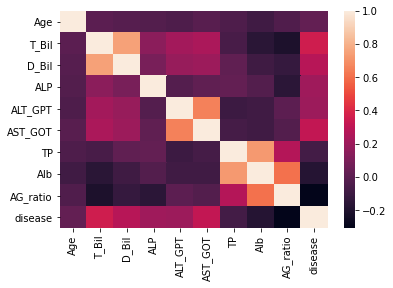

In [6]:
sns.heatmap(train.corr())

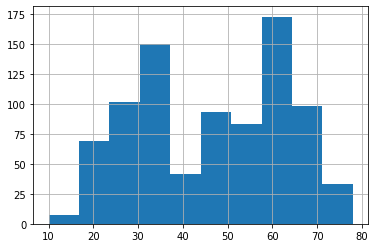

In [7]:
train['Age'].hist()
plt.show()

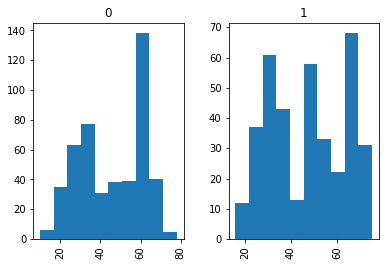

In [8]:
train['Age'].hist(by=train['disease'])
plt.show()

In [9]:
train["Age_cls"] = pd.cut(train['Age'], [0, 30, 45, 60, 100], labels=['0_30', '30_45', '45_60', '60_100'])
test["Age_cls"] = pd.cut(test['Age'], [0, 30, 45, 60, 100], labels=['0_30', '30_45', '45_60', '60_100'])

### 外れ値処理

In [10]:
num_list = list(test.select_dtypes(exclude=object).columns[:9])
num_list

['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

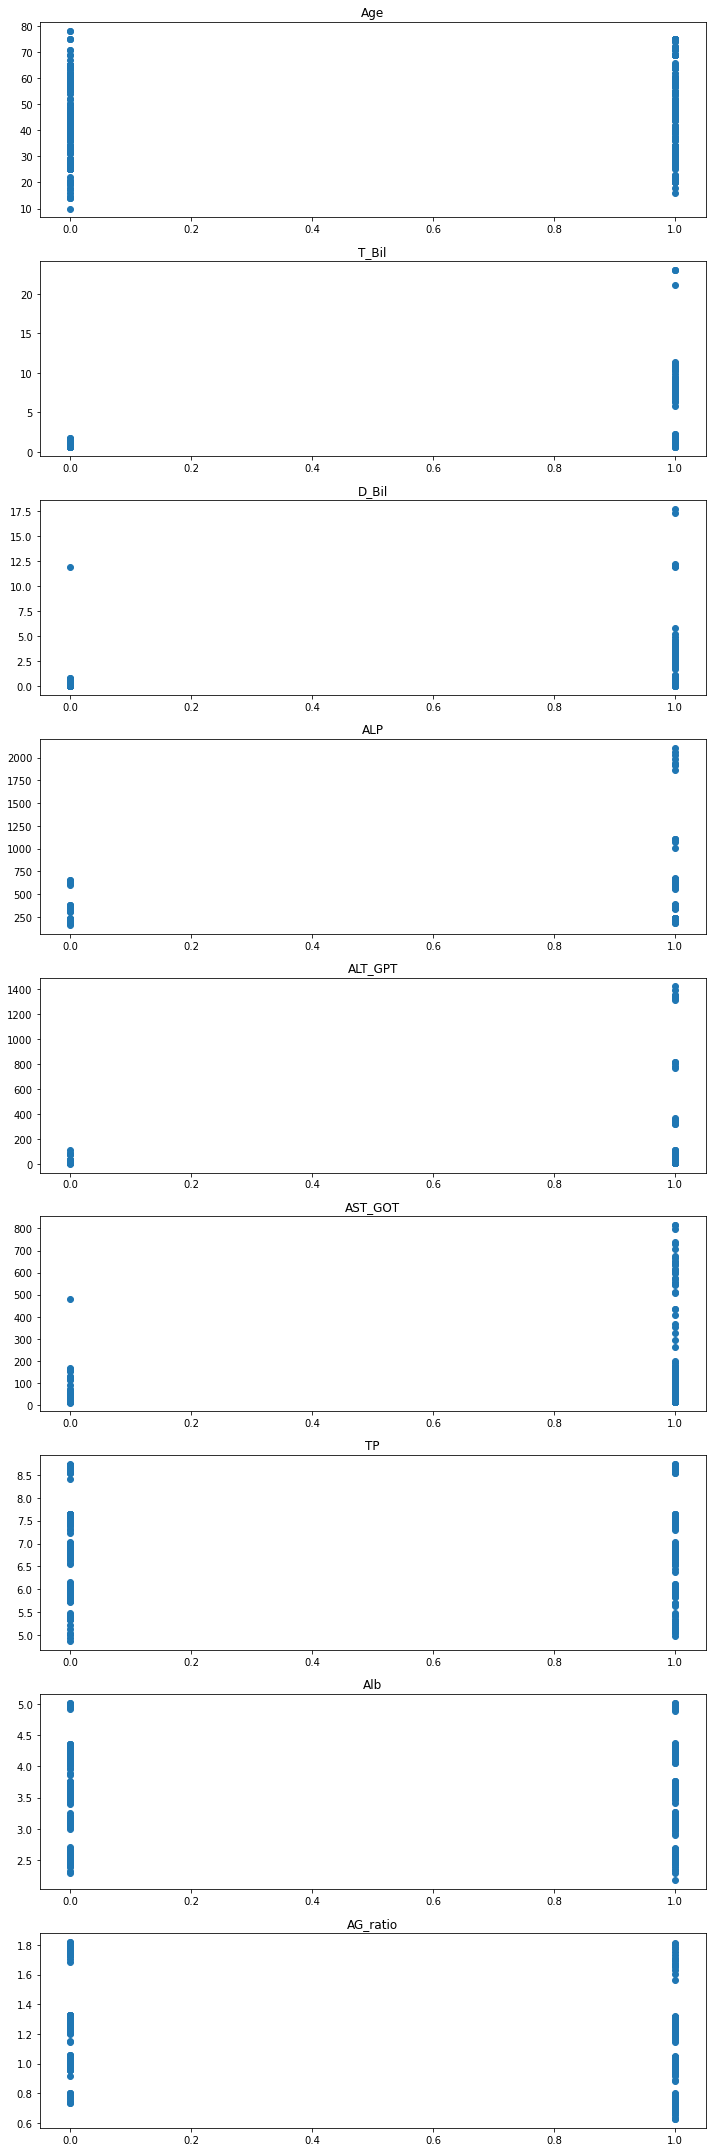

In [11]:
# diseaseごとの各カラムの散布図を見て外れ値を探す

fig = plt.figure(figsize=(10,30))

for i in range(len(num_list)):
    plt.subplot(9, 1, i+1)
    plt.title(num_list[i])
    plt.scatter(train['disease'], train[num_list[i]])

plt.tight_layout()

In [12]:
# Age 削除対象
display(train[(train['Age']>75) & (train['disease']==0)])
display(train[(train['Age']<12) & (train['disease']==0)])

train = train.drop(train[(train['Age']>75) & (train['disease']==0)].index)
train = train.drop(train[(train['Age']<12) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls
268,78,Male,0.810486,0.197167,213.961347,15.247348,20.931720,7.530853,3.634814,1.285051,0,60_100
475,78,Male,0.717658,0.164531,207.302298,9.473956,21.145924,6.864853,3.600574,1.311394,0,60_100


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls
402,10,Male,0.767137,0.173513,214.651243,13.132598,20.931029,7.536683,4.212869,1.288729,0,0_30


In [13]:
# T-Bil 削除対象
display(train[train['T_Bil']>15])

# 削除
train = train.drop(train[train['T_Bil']>15].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls
69,26,Male,23.017027,11.992452,214.777736,12.921732,98.892019,7.595521,3.585702,0.987575,1,0_30
240,50,Female,21.184706,17.264120,214.413921,16.616958,28.436753,8.639342,3.089583,1.225404,1,45_60
297,32,Male,23.013928,17.692164,206.635298,10.197751,22.378512,5.844967,3.136777,1.184554,1,30_45
468,32,Male,23.002653,11.978404,1861.148040,23.111268,62.911839,6.882093,3.203098,0.913798,1,30_45


In [14]:
# D-Bil 削除対象
display(train[train['D_Bil']>10])

train = train.drop(train[train['D_Bil']>10].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls
119,47,Male,0.874862,12.140346,212.041216,44.877908,104.234557,8.612374,3.520750,1.215675,1,45_60
130,42,Male,0.930668,11.935322,197.000997,10.514899,14.825766,7.581402,3.659571,1.024392,0,30_45
363,59,Male,0.972024,11.908908,217.020581,13.980081,59.748856,8.661666,3.663260,1.289892,1,45_60
766,65,Male,0.858532,12.033170,220.387128,17.155909,80.863658,7.629307,4.123316,1.184591,1,60_100
826,32,Male,0.983627,12.201824,218.317890,10.606974,75.159134,7.602828,3.685454,0.987741,1,30_45


In [15]:
# AST-GOT 削除対象
display(train[(train['AST_GOT']>400) & (train['disease']==0)])

train = train.drop(train[(train['AST_GOT']>400) & (train['disease']==0)].index)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Age_cls
662,75,Male,1.465158,0.767795,366.834104,116.407037,481.935324,8.631458,4.337368,1.262153,0,60_100


### カテゴリデータの可視化

<AxesSubplot:title={'center':'train Gender'}, xlabel='Gender'>

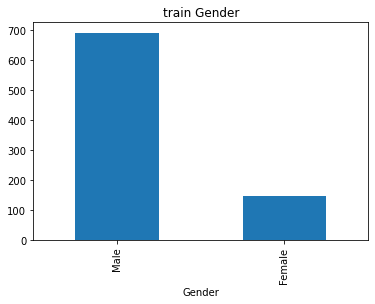

In [16]:
train.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="train Gender")

<AxesSubplot:title={'center':'test Gender'}, xlabel='Gender'>

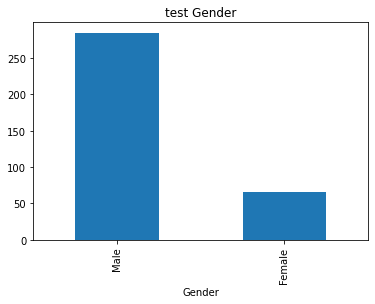

In [17]:
test.groupby("Gender")["Gender"].count().sort_values(ascending=False).plot(kind="bar", title="test Gender")

### 欠損値処理

In [18]:
display(train.isnull().sum())
display(test.isnull().sum())

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
Age_cls     0
dtype: int64

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
Age_cls     0
dtype: int64

### ラベルエンコーディング

In [19]:
lbl = preprocessing.LabelEncoder()

In [20]:
train["Gender"] = lbl.fit_transform(train["Gender"])
test["Gender"] = lbl.fit_transform(test["Gender"])

### 特徴量選択

In [21]:
features = ['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### Filter Method

In [22]:
train.corr()["disease"]

Age         0.030424
Gender      0.107368
T_Bil       0.390404
D_Bil       0.384449
ALP         0.213185
ALT_GPT     0.202359
AST_GOT     0.324016
TP         -0.079806
Alb        -0.174934
AG_ratio   -0.308226
disease     1.000000
Name: disease, dtype: float64

In [23]:
# D_Bil	T_Bil 0.930493

# disease T_Bil 0.390951
# disease D_Bil 0.384931 -> こちらを削除
train.corr()[abs(train.corr()) > 0.8]

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
Age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T_Bil,NaN,NaN,1.000000,0.930462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D_Bil,NaN,NaN,0.930462,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ALT_GPT,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
AST_GOT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Alb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
AG_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [24]:
features = ['Age', 'Gender', 'T_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']

### データの分割

In [25]:
# testデータに復元用のNo.を振る
serial_num = pd.RangeIndex(start=1, stop=test.shape[0]+1, step=1)
test['No'] = serial_num

In [26]:
test["Age_cls"].unique()

['0_30', '60_100', '30_45', '45_60']
Categories (4, object): ['0_30' < '30_45' < '45_60' < '60_100']

In [27]:
# 0_30歳代
train_0_30 = train[train["Age_cls"] == "0_30"]
test_0_30 = test[test["Age_cls"] == "0_30"]

In [28]:
# 30_45歳代
train_30_45 = train[train["Age_cls"] == "30_45"]
test_30_45 = test[test["Age_cls"] == "30_45"]

In [29]:
# 45_60歳代
train_45_60 = train[train["Age_cls"] == "45_60"]
test_45_60 = test[test["Age_cls"] == "45_60"]

In [30]:
# 60_100歳代
train_60_100 = train[train["Age_cls"] == "60_100"]
test_60_100 = test[test["Age_cls"] == "60_100"]

### ホールドアウト法

In [31]:
# 0_30歳代データ
X_train_0_30, X_test_0_30, y_train_0_30, y_test_0_30 = train_test_split(train_0_30[features], 
                                                                        train_0_30["disease"], test_size=0.3, random_state=42)

In [32]:
# 30_45歳代データ
X_train_30_45, X_test_30_45, y_train_30_45, y_test_30_45 = train_test_split(train_30_45[features], 
                                                    train_30_45["disease"], test_size=0.3, random_state=42)

In [33]:
# 45_60歳代データ
X_train_45_60, X_test_45_60, y_train_45_60, y_test_45_60 = train_test_split(train_45_60[features], 
                                                    train_45_60["disease"], test_size=0.3, random_state=42)

In [34]:
# 60_100歳代データ
X_train_60_100, X_test_60_100, y_train_60_100, y_test_60_100 = train_test_split(train_60_100[features], 
                                                    train_60_100["disease"], test_size=0.3, random_state=42)

### 学習

#### lightGBM

In [35]:
# 0_30歳代データ
train_set_0_30 = lgb.Dataset(X_train_0_30, y_train_0_30)
val_set_0_30 = lgb.Dataset(X_test_0_30, y_test_0_30, reference=train_set_0_30)

In [36]:
# 30_45歳代データ
train_set_30_45 = lgb.Dataset(X_train_30_45, y_train_30_45)
val_set_30_45 = lgb.Dataset(X_test_30_45, y_test_30_45, reference=train_set_30_45)

In [37]:
# 45_60歳代データ
train_set_45_60 = lgb.Dataset(X_train_45_60, y_train_45_60)
val_set_45_60 = lgb.Dataset(X_test_45_60, y_test_45_60, reference=train_set_45_60)

In [38]:
# 60_100歳代データ
train_set_60_100 = lgb.Dataset(X_train_60_100, y_train_60_100)
val_set_60_100 = lgb.Dataset(X_test_60_100, y_test_60_100, reference=train_set_60_100)

In [39]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'verbosity': -1,
    'seed': 42,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75,
}

In [40]:
# 0_30歳代データ
model_lgb_0_30 = lgb.train(params, train_set_0_30, valid_sets=val_set_0_30,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.880805
[100]	valid_0's auc: 0.886997
Early stopping, best iteration is:
[37]	valid_0's auc: 0.891641


feature_fraction, val_score: 0.891641:  14%|#4        | 1/7 [00:00<00:00,  6.85it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.891641
[100]	valid_0's auc: 0.888545
[150]	valid_0's auc: 0.897833
[200]	valid_0's auc: 0.894737
[250]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[159]	valid_0's auc: 0.902477


feature_fraction, val_score: 0.902477:  29%|##8       | 2/7 [00:00<00:00,  8.85it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.880805
Early stopping, best iteration is:
[35]	valid_0's auc: 0.896285


feature_fraction, val_score: 0.902477:  43%|####2     | 3/7 [00:00<00:00,  8.18it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


feature_fraction, val_score: 0.904025:  57%|#####7    | 4/7 [00:00<00:00,  7.67it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.894737
[150]	valid_0's auc: 0.894737
[200]	valid_0's auc: 0.893189
[250]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[160]	valid_0's auc: 0.902477


feature_fraction, val_score: 0.904025:  71%|#######1  | 5/7 [00:00<00:00,  7.00it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.899381
[100]	valid_0's auc: 0.899381
Early stopping, best iteration is:
[41]	valid_0's auc: 0.902477


feature_fraction, val_score: 0.904025:  86%|########5 | 6/7 [00:00<00:00,  6.96it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.891641
[100]	valid_0's auc: 0.888545
[150]	valid_0's auc: 0.897833
[200]	valid_0's auc: 0.894737
[250]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[159]	valid_0's auc: 0.902477


num_leaves, val_score: 0.904025:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904025:   5%|5         | 1/20 [00:00<00:02,  7.14it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904025:  10%|#         | 2/20 [00:00<00:01, 10.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904025:  15%|#5        | 3/20 [00:00<00:01,  8.83it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904025:  20%|##        | 4/20 [00:00<00:01,  8.16it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.891641
[100]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[40]	valid_0's auc: 0.904799


num_leaves, val_score: 0.904799:  25%|##5       | 5/20 [00:00<00:01,  7.85it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  30%|###       | 6/20 [00:00<00:01,  7.50it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  35%|###5      | 7/20 [00:01<00:01,  7.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  40%|####      | 8/20 [00:01<00:01,  7.21it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  45%|####5     | 9/20 [00:01<00:01,  7.07it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  50%|#####     | 10/20 [00:01<00:01,  7.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  55%|#####5    | 11/20 [00:01<00:01,  6.25it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  60%|######    | 12/20 [00:01<00:01,  6.41it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.881579
[100]	valid_0's auc: 0.876161
[150]	valid_0's auc: 0.891641
[200]	valid_0's auc: 0.888545
[250]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[156]	valid_0's auc: 0.897833


num_leaves, val_score: 0.904799:  65%|######5   | 13/20 [00:01<00:01,  6.19it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  70%|#######   | 14/20 [00:02<00:00,  6.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  75%|#######5  | 15/20 [00:02<00:00,  6.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  80%|########  | 16/20 [00:02<00:00,  6.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  85%|########5 | 17/20 [00:02<00:00,  6.65it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  90%|######### | 18/20 [00:02<00:00,  6.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.896285
Early stopping, best iteration is:
[45]	valid_0's auc: 0.904025


num_leaves, val_score: 0.904799:  95%|#########5| 19/20 [00:02<00:00,  6.55it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.891641
[100]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[40]	valid_0's auc: 0.904799


bagging, val_score: 0.904799:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.885449
[100]	valid_0's auc: 0.883901
[150]	valid_0's auc: 0.880805
Early stopping, best iteration is:
[52]	valid_0's auc: 0.893189


bagging, val_score: 0.904799:  10%|#         | 1/10 [00:00<00:01,  6.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.887771
[150]	valid_0's auc: 0.882353
Early stopping, best iteration is:
[50]	valid_0's auc: 0.896285


bagging, val_score: 0.904799:  20%|##        | 2/10 [00:00<00:00,  9.90it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.883901
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[39]	valid_0's auc: 0.893189


bagging, val_score: 0.904799:  30%|###       | 3/10 [00:00<00:00,  8.83it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.883901
[100]	valid_0's auc: 0.869969
Early stopping, best iteration is:
[47]	valid_0's auc: 0.886997


bagging, val_score: 0.904799:  40%|####      | 4/10 [00:00<00:00,  8.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.882353
[100]	valid_0's auc: 0.891641
Early stopping, best iteration is:
[13]	valid_0's auc: 0.897059


bagging, val_score: 0.904799:  50%|#####     | 5/10 [00:00<00:00,  8.04it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.881579
[100]	valid_0's auc: 0.886997
[150]	valid_0's auc: 0.885449
Early stopping, best iteration is:
[83]	valid_0's auc: 0.894737


bagging, val_score: 0.904799:  60%|######    | 6/10 [00:00<00:00,  7.64it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.888545
[100]	valid_0's auc: 0.893189
Early stopping, best iteration is:
[4]	valid_0's auc: 0.900155


bagging, val_score: 0.904799:  70%|#######   | 7/10 [00:00<00:00,  7.50it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


bagging, val_score: 0.907121:  80%|########  | 8/10 [00:01<00:00,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.886997
[150]	valid_0's auc: 0.880805
Early stopping, best iteration is:
[75]	valid_0's auc: 0.894737


bagging, val_score: 0.907121:  90%|######### | 9/10 [00:01<00:00,  7.03it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.891641
Early stopping, best iteration is:
[12]	valid_0's auc: 0.906347


feature_fraction_stage2, val_score: 0.907121:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


feature_fraction_stage2, val_score: 0.907121:  17%|#6        | 1/6 [00:00<00:00,  6.33it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


feature_fraction_stage2, val_score: 0.907121:  33%|###3      | 2/6 [00:00<00:00, 10.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


feature_fraction_stage2, val_score: 0.907121:  50%|#####     | 3/6 [00:00<00:00,  8.84it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.894737
[100]	valid_0's auc: 0.900929
Early stopping, best iteration is:
[31]	valid_0's auc: 0.902477


feature_fraction_stage2, val_score: 0.907121:  67%|######6   | 4/6 [00:00<00:00,  8.27it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


feature_fraction_stage2, val_score: 0.907121:  83%|########3 | 5/6 [00:00<00:00,  7.97it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.894737
[100]	valid_0's auc: 0.902477
Early stopping, best iteration is:
[11]	valid_0's auc: 0.906347


regularization_factors, val_score: 0.907121:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.885449
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.905573


regularization_factors, val_score: 0.907121:   5%|5         | 1/20 [00:00<00:02,  7.30it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.890093
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  10%|#         | 2/20 [00:00<00:01, 10.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  15%|#5        | 3/20 [00:00<00:01,  9.02it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.885449
Early stopping, best iteration is:
[7]	valid_0's auc: 0.905573


regularization_factors, val_score: 0.907121:  20%|##        | 4/20 [00:00<00:01,  8.28it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.884675
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[32]	valid_0's auc: 0.890093


regularization_factors, val_score: 0.907121:  25%|##5       | 5/20 [00:00<00:01,  7.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.888545
[100]	valid_0's auc: 0.886997
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  30%|###       | 6/20 [00:00<00:01,  7.16it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.888545
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.905573


regularization_factors, val_score: 0.907121:  35%|###5      | 7/20 [00:01<00:01,  7.17it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.883901
[100]	valid_0's auc: 0.885449
Early stopping, best iteration is:
[7]	valid_0's auc: 0.906347


regularization_factors, val_score: 0.907121:  40%|####      | 8/20 [00:01<00:01,  7.19it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  45%|####5     | 9/20 [00:01<00:01,  7.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.884675
[100]	valid_0's auc: 0.887771
Early stopping, best iteration is:
[22]	valid_0's auc: 0.889319


regularization_factors, val_score: 0.907121:  50%|#####     | 10/20 [00:01<00:01,  7.44it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  55%|#####5    | 11/20 [00:01<00:01,  7.31it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  60%|######    | 12/20 [00:01<00:01,  7.29it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  65%|######5   | 13/20 [00:01<00:00,  7.38it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.888545
[100]	valid_0's auc: 0.883901
Early stopping, best iteration is:
[7]	valid_0's auc: 0.906347


regularization_factors, val_score: 0.907121:  70%|#######   | 14/20 [00:01<00:00,  7.50it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  75%|#######5  | 15/20 [00:02<00:00,  7.58it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  80%|########  | 16/20 [00:02<00:00,  7.54it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  85%|########5 | 17/20 [00:02<00:00,  7.38it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  90%|######### | 18/20 [00:02<00:00,  7.17it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.890093
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[7]	valid_0's auc: 0.907121


regularization_factors, val_score: 0.907121:  95%|#########5| 19/20 [00:02<00:00,  7.22it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.888545
Early stopping, best iteration is:
[38]	valid_0's auc: 0.891641


min_data_in_leaf, val_score: 0.907121:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.907121:  20%|##        | 1/5 [00:00<00:00,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.883901
Early stopping, best iteration is:
[6]	valid_0's auc: 0.901703


min_data_in_leaf, val_score: 0.907121:  40%|####      | 2/5 [00:00<00:00, 11.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.886997
[100]	valid_0's auc: 0.886997
Early stopping, best iteration is:
[4]	valid_0's auc: 0.905573


min_data_in_leaf, val_score: 0.907121:  60%|######    | 3/5 [00:00<00:00,  9.82it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.894737
[100]	valid_0's auc: 0.880031
Early stopping, best iteration is:
[29]	valid_0's auc: 0.900155


min_data_in_leaf, val_score: 0.907121:  80%|########  | 4/5 [00:00<00:00,  8.90it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.896285
[100]	valid_0's auc: 0.891641
Early stopping, best iteration is:
[47]	valid_0's auc: 0.897833


min_data_in_leaf, val_score: 0.907121: 100%|##########| 5/5 [00:00<00:00,  7.26it/s]


In [41]:
# 30_45歳代データ
model_lgb_30_45 = lgb.train(params, train_set_30_45, valid_sets=val_set_30_45,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.784744
[100]	valid_0's auc: 0.770115
Early stopping, best iteration is:
[11]	valid_0's auc: 0.797806


feature_fraction, val_score: 0.797806:  14%|#4        | 1/7 [00:00<00:00,  6.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.772205
[100]	valid_0's auc: 0.751306
Early stopping, best iteration is:
[27]	valid_0's auc: 0.783699


feature_fraction, val_score: 0.797806:  29%|##8       | 2/7 [00:00<00:00, 10.10it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


feature_fraction, val_score: 0.799896:  43%|####2     | 3/7 [00:00<00:00,  9.13it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.761755
[150]	valid_0's auc: 0.772205
Early stopping, best iteration is:
[58]	valid_0's auc: 0.781609


feature_fraction, val_score: 0.799896:  57%|#####7    | 4/7 [00:00<00:00,  7.96it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.77116
[100]	valid_0's auc: 0.765935
Early stopping, best iteration is:
[4]	valid_0's auc: 0.777429


feature_fraction, val_score: 0.799896:  71%|#######1  | 5/7 [00:00<00:00,  7.83it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.77534
Early stopping, best iteration is:
[6]	valid_0's auc: 0.779519


feature_fraction, val_score: 0.799896:  86%|########5 | 6/7 [00:00<00:00,  7.77it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:   5%|5         | 1/20 [00:00<00:02,  6.94it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  10%|#         | 2/20 [00:00<00:01, 10.58it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  15%|#5        | 3/20 [00:00<00:01,  9.27it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  20%|##        | 4/20 [00:00<00:01,  8.16it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  25%|##5       | 5/20 [00:00<00:02,  7.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  30%|###       | 6/20 [00:00<00:01,  7.35it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  35%|###5      | 7/20 [00:01<00:01,  7.27it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  40%|####      | 8/20 [00:01<00:01,  7.48it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  45%|####5     | 9/20 [00:01<00:01,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  50%|#####     | 10/20 [00:01<00:01,  7.61it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  55%|#####5    | 11/20 [00:01<00:01,  7.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  60%|######    | 12/20 [00:01<00:01,  7.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  65%|######5   | 13/20 [00:01<00:00,  7.38it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  70%|#######   | 14/20 [00:01<00:00,  7.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  75%|#######5  | 15/20 [00:02<00:00,  7.32it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  80%|########  | 16/20 [00:02<00:00,  7.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  85%|########5 | 17/20 [00:02<00:00,  7.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  90%|######### | 18/20 [00:02<00:00,  7.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


num_leaves, val_score: 0.799896:  95%|#########5| 19/20 [00:02<00:00,  7.48it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76698
[100]	valid_0's auc: 0.774295
Early stopping, best iteration is:
[6]	valid_0's auc: 0.799896


bagging, val_score: 0.799896:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


bagging, val_score: 0.829154:  10%|#         | 1/10 [00:00<00:01,  7.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.801463
[100]	valid_0's auc: 0.781609
Early stopping, best iteration is:
[4]	valid_0's auc: 0.810345


bagging, val_score: 0.829154:  20%|##        | 2/10 [00:00<00:00, 11.36it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.798328
[100]	valid_0's auc: 0.795193
[150]	valid_0's auc: 0.796238
Early stopping, best iteration is:
[54]	valid_0's auc: 0.808777


bagging, val_score: 0.829154:  30%|###       | 3/10 [00:00<00:00,  9.30it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.770637
[100]	valid_0's auc: 0.76698
[150]	valid_0's auc: 0.755486
Early stopping, best iteration is:
[64]	valid_0's auc: 0.789446


bagging, val_score: 0.829154:  40%|####      | 4/10 [00:00<00:00,  8.27it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.772205
[100]	valid_0's auc: 0.770115
Early stopping, best iteration is:
[2]	valid_0's auc: 0.796761


bagging, val_score: 0.829154:  50%|#####     | 5/10 [00:00<00:00,  7.97it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.746082
[100]	valid_0's auc: 0.768025
Early stopping, best iteration is:
[17]	valid_0's auc: 0.799896


bagging, val_score: 0.829154:  60%|######    | 6/10 [00:00<00:00,  7.55it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.788924
[100]	valid_0's auc: 0.784744
Early stopping, best iteration is:
[5]	valid_0's auc: 0.827586


bagging, val_score: 0.829154:  70%|#######   | 7/10 [00:00<00:00,  7.42it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.809822
[100]	valid_0's auc: 0.794148
Early stopping, best iteration is:
[6]	valid_0's auc: 0.816092


bagging, val_score: 0.829154:  80%|########  | 8/10 [00:01<00:00,  7.35it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.784744
[100]	valid_0's auc: 0.798328
Early stopping, best iteration is:
[7]	valid_0's auc: 0.822362


bagging, val_score: 0.829154:  90%|######### | 9/10 [00:01<00:00,  6.60it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.786834
[100]	valid_0's auc: 0.799373
[150]	valid_0's auc: 0.783699
Early stopping, best iteration is:
[93]	valid_0's auc: 0.802508


feature_fraction_stage2, val_score: 0.829154:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76907
[100]	valid_0's auc: 0.7628
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


feature_fraction_stage2, val_score: 0.829154:  17%|#6        | 1/6 [00:00<00:00,  6.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76907
[100]	valid_0's auc: 0.7628
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


feature_fraction_stage2, val_score: 0.829154:  33%|###3      | 2/6 [00:00<00:00, 10.15it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


feature_fraction_stage2, val_score: 0.829154:  50%|#####     | 3/6 [00:00<00:00,  8.92it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


feature_fraction_stage2, val_score: 0.829154:  67%|######6   | 4/6 [00:00<00:00,  8.14it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.76907
[100]	valid_0's auc: 0.7628
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


feature_fraction_stage2, val_score: 0.829154:  83%|########3 | 5/6 [00:00<00:00,  7.74it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.795193
[100]	valid_0's auc: 0.786834
Early stopping, best iteration is:
[6]	valid_0's auc: 0.820272


regularization_factors, val_score: 0.829154:   5%|5         | 1/20 [00:00<00:02,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.768025
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:  10%|#         | 2/20 [00:00<00:01, 11.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:  15%|#5        | 3/20 [00:00<00:01, 10.09it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:  20%|##        | 4/20 [00:00<00:01,  9.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.759666
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:  25%|##5       | 5/20 [00:00<00:01,  8.58it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.829154:  30%|###       | 6/20 [00:00<00:01,  8.21it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.779519
Early stopping, best iteration is:
[4]	valid_0's auc: 0.831243


regularization_factors, val_score: 0.831243:  35%|###5      | 7/20 [00:00<00:01,  8.15it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  40%|####      | 8/20 [00:01<00:01,  8.14it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.793103
[100]	valid_0's auc: 0.789969
Early stopping, best iteration is:
[6]	valid_0's auc: 0.815569


regularization_factors, val_score: 0.831243:  45%|####5     | 9/20 [00:01<00:01,  8.10it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.793103
[100]	valid_0's auc: 0.760711
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  50%|#####     | 10/20 [00:01<00:01,  8.01it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.778474
Early stopping, best iteration is:
[4]	valid_0's auc: 0.831243


regularization_factors, val_score: 0.831243:  55%|#####5    | 11/20 [00:01<00:01,  7.86it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.774295
[100]	valid_0's auc: 0.782654
Early stopping, best iteration is:
[7]	valid_0's auc: 0.816092


regularization_factors, val_score: 0.831243:  60%|######    | 12/20 [00:01<00:01,  7.82it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  65%|######5   | 13/20 [00:01<00:00,  7.73it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.778474
[100]	valid_0's auc: 0.76489
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  70%|#######   | 14/20 [00:01<00:00,  7.53it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.759666
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  75%|#######5  | 15/20 [00:01<00:00,  7.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.789969
[100]	valid_0's auc: 0.780564
Early stopping, best iteration is:
[7]	valid_0's auc: 0.823929


regularization_factors, val_score: 0.831243:  80%|########  | 16/20 [00:02<00:00,  7.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.758621
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  85%|########5 | 17/20 [00:02<00:00,  7.50it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.779519
[100]	valid_0's auc: 0.756531
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  90%|######### | 18/20 [00:02<00:00,  7.42it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.788924
[100]	valid_0's auc: 0.76489
Early stopping, best iteration is:
[2]	valid_0's auc: 0.829154


regularization_factors, val_score: 0.831243:  95%|#########5| 19/20 [00:02<00:00,  7.44it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.777429
[100]	valid_0's auc: 0.777429
Early stopping, best iteration is:
[7]	valid_0's auc: 0.816092


min_data_in_leaf, val_score: 0.831243:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.793103
[100]	valid_0's auc: 0.795193
Early stopping, best iteration is:
[6]	valid_0's auc: 0.819227


min_data_in_leaf, val_score: 0.831243:  20%|##        | 1/5 [00:00<00:00,  6.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.831243:  40%|####      | 2/5 [00:00<00:00, 11.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.77534
[100]	valid_0's auc: 0.781609
Early stopping, best iteration is:
[6]	valid_0's auc: 0.835423


min_data_in_leaf, val_score: 0.835423:  60%|######    | 3/5 [00:00<00:00,  9.33it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.783699
[100]	valid_0's auc: 0.781609
Early stopping, best iteration is:
[7]	valid_0's auc: 0.830721


min_data_in_leaf, val_score: 0.835423:  80%|########  | 4/5 [00:00<00:00,  8.68it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.835423: 100%|##########| 5/5 [00:00<00:00,  7.44it/s]


In [42]:
# 45_60歳代データ
model_lgb_45_60 = lgb.train(params, train_set_45_60, valid_sets=val_set_45_60,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.940379
[100]	valid_0's auc: 0.934056
[150]	valid_0's auc: 0.921409
Early stopping, best iteration is:
[58]	valid_0's auc: 0.953026


feature_fraction, val_score: 0.953026:  14%|#4        | 1/7 [00:00<00:00,  6.29it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.937669
[100]	valid_0's auc: 0.937669
Early stopping, best iteration is:
[45]	valid_0's auc: 0.943089


feature_fraction, val_score: 0.953026:  29%|##8       | 2/7 [00:00<00:00,  9.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


feature_fraction, val_score: 0.956640:  43%|####2     | 3/7 [00:00<00:00,  8.10it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.932249
[100]	valid_0's auc: 0.930443
[150]	valid_0's auc: 0.914182
Early stopping, best iteration is:
[66]	valid_0's auc: 0.939476


feature_fraction, val_score: 0.956640:  57%|#####7    | 4/7 [00:00<00:00,  7.54it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.939476
[100]	valid_0's auc: 0.927733
Early stopping, best iteration is:
[32]	valid_0's auc: 0.940379


feature_fraction, val_score: 0.956640:  71%|#######1  | 5/7 [00:00<00:00,  7.29it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.932249
[100]	valid_0's auc: 0.930443
[150]	valid_0's auc: 0.914182
Early stopping, best iteration is:
[66]	valid_0's auc: 0.939476


feature_fraction, val_score: 0.956640:  86%|########5 | 6/7 [00:00<00:00,  7.06it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.929539
[100]	valid_0's auc: 0.925023
[150]	valid_0's auc: 0.915989
Early stopping, best iteration is:
[67]	valid_0's auc: 0.937669


num_leaves, val_score: 0.956640:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:   5%|5         | 1/20 [00:00<00:03,  6.02it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  10%|#         | 2/20 [00:00<00:02,  8.03it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  15%|#5        | 3/20 [00:00<00:02,  7.37it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  20%|##        | 4/20 [00:00<00:02,  6.71it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  25%|##5       | 5/20 [00:00<00:02,  6.39it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  30%|###       | 6/20 [00:01<00:02,  6.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  35%|###5      | 7/20 [00:01<00:02,  6.00it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  40%|####      | 8/20 [00:01<00:02,  5.86it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  45%|####5     | 9/20 [00:01<00:01,  5.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  50%|#####     | 10/20 [00:01<00:01,  5.89it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  55%|#####5    | 11/20 [00:01<00:01,  5.79it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  60%|######    | 12/20 [00:02<00:01,  5.87it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  65%|######5   | 13/20 [00:02<00:01,  5.86it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  70%|#######   | 14/20 [00:02<00:01,  5.79it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  75%|#######5  | 15/20 [00:02<00:00,  5.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  80%|########  | 16/20 [00:02<00:00,  5.74it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  85%|########5 | 17/20 [00:02<00:00,  5.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


num_leaves, val_score: 0.956640:  90%|######### | 18/20 [00:03<00:00,  5.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953026
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.941283
Early stopping, best iteration is:
[63]	valid_0's auc: 0.960253


num_leaves, val_score: 0.960253:  95%|#########5| 19/20 [00:03<00:00,  5.90it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945799
[100]	valid_0's auc: 0.95122
[150]	valid_0's auc: 0.941283
[200]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[109]	valid_0's auc: 0.95664


bagging, val_score: 0.960253:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.949413
[100]	valid_0's auc: 0.934959
[150]	valid_0's auc: 0.943993
Early stopping, best iteration is:
[60]	valid_0's auc: 0.953026


bagging, val_score: 0.960253:  10%|#         | 1/10 [00:00<00:01,  6.94it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.950316
[100]	valid_0's auc: 0.953026
[150]	valid_0's auc: 0.949413
Early stopping, best iteration is:
[62]	valid_0's auc: 0.95664


bagging, val_score: 0.960253:  20%|##        | 2/10 [00:00<00:00, 10.15it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.938573
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.944896
[200]	valid_0's auc: 0.935863
Early stopping, best iteration is:
[103]	valid_0's auc: 0.954833


bagging, val_score: 0.960253:  30%|###       | 3/10 [00:00<00:00,  8.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946703
[100]	valid_0's auc: 0.931346
Early stopping, best iteration is:
[33]	valid_0's auc: 0.955736


bagging, val_score: 0.960253:  40%|####      | 4/10 [00:00<00:00,  7.99it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


bagging, val_score: 0.962963:  50%|#####     | 5/10 [00:00<00:00,  7.59it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.943993
[100]	valid_0's auc: 0.937669
Early stopping, best iteration is:
[32]	valid_0's auc: 0.946703


bagging, val_score: 0.962963:  60%|######    | 6/10 [00:00<00:00,  7.54it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.940379
[100]	valid_0's auc: 0.943089
[150]	valid_0's auc: 0.948509
[200]	valid_0's auc: 0.934056
Early stopping, best iteration is:
[132]	valid_0's auc: 0.950316


bagging, val_score: 0.962963:  70%|#######   | 7/10 [00:01<00:00,  7.01it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.957543
[100]	valid_0's auc: 0.941283
[150]	valid_0's auc: 0.95393
Early stopping, best iteration is:
[50]	valid_0's auc: 0.957543


bagging, val_score: 0.962963:  80%|########  | 8/10 [00:01<00:00,  6.96it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.944896
[100]	valid_0's auc: 0.940379
Early stopping, best iteration is:
[31]	valid_0's auc: 0.952123


bagging, val_score: 0.962963:  90%|######### | 9/10 [00:01<00:00,  6.96it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.947606
[100]	valid_0's auc: 0.949413
[150]	valid_0's auc: 0.947606
[200]	valid_0's auc: 0.945799
Early stopping, best iteration is:
[129]	valid_0's auc: 0.954833


feature_fraction_stage2, val_score: 0.962963:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.943993
[100]	valid_0's auc: 0.937669
[150]	valid_0's auc: 0.942186
Early stopping, best iteration is:
[62]	valid_0's auc: 0.950316


feature_fraction_stage2, val_score: 0.962963:  33%|###3      | 1/3 [00:00<00:00,  6.10it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.943993
[100]	valid_0's auc: 0.937669
[150]	valid_0's auc: 0.942186
Early stopping, best iteration is:
[62]	valid_0's auc: 0.950316


feature_fraction_stage2, val_score: 0.962963:  67%|######6   | 2/3 [00:00<00:00,  9.13it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.962963:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.950316
[100]	valid_0's auc: 0.948509
[150]	valid_0's auc: 0.943993
Early stopping, best iteration is:
[59]	valid_0's auc: 0.96206


regularization_factors, val_score: 0.962963:   5%|5         | 1/20 [00:00<00:02,  6.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.949413
[100]	valid_0's auc: 0.949413
[150]	valid_0's auc: 0.945799
Early stopping, best iteration is:
[59]	valid_0's auc: 0.960253


regularization_factors, val_score: 0.962963:  10%|#         | 2/20 [00:00<00:01,  9.95it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.962963:  15%|#5        | 3/20 [00:00<00:01,  8.92it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.962963:  20%|##        | 4/20 [00:00<00:01,  8.12it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.952123
[100]	valid_0's auc: 0.942186
[150]	valid_0's auc: 0.942186
Early stopping, best iteration is:
[60]	valid_0's auc: 0.955736


regularization_factors, val_score: 0.962963:  25%|##5       | 5/20 [00:00<00:02,  7.30it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.936766
[100]	valid_0's auc: 0.941283
[150]	valid_0's auc: 0.942186
[200]	valid_0's auc: 0.942186
Early stopping, best iteration is:
[118]	valid_0's auc: 0.943089


regularization_factors, val_score: 0.962963:  30%|###       | 6/20 [00:00<00:02,  6.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.953026
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[59]	valid_0's auc: 0.963866


regularization_factors, val_score: 0.963866:  35%|###5      | 7/20 [00:01<00:01,  6.60it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.947606
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.953026
[200]	valid_0's auc: 0.953026
Early stopping, best iteration is:
[111]	valid_0's auc: 0.953026


regularization_factors, val_score: 0.963866:  40%|####      | 8/20 [00:01<00:01,  6.49it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  45%|####5     | 9/20 [00:01<00:01,  6.62it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  50%|#####     | 10/20 [00:01<00:01,  6.61it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  55%|#####5    | 11/20 [00:01<00:01,  6.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95393
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.946703
Early stopping, best iteration is:
[57]	valid_0's auc: 0.957543


regularization_factors, val_score: 0.963866:  60%|######    | 12/20 [00:01<00:01,  6.68it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.949413
[100]	valid_0's auc: 0.949413
[150]	valid_0's auc: 0.946703
Early stopping, best iteration is:
[59]	valid_0's auc: 0.960253


regularization_factors, val_score: 0.963866:  65%|######5   | 13/20 [00:01<00:01,  6.62it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  70%|#######   | 14/20 [00:02<00:00,  6.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.949413
[100]	valid_0's auc: 0.949413
[150]	valid_0's auc: 0.944896
Early stopping, best iteration is:
[59]	valid_0's auc: 0.960253


regularization_factors, val_score: 0.963866:  75%|#######5  | 15/20 [00:02<00:00,  6.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.950316
[150]	valid_0's auc: 0.947606
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  80%|########  | 16/20 [00:02<00:00,  6.87it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.949413
[100]	valid_0's auc: 0.942186
[150]	valid_0's auc: 0.944896
Early stopping, best iteration is:
[59]	valid_0's auc: 0.952123


regularization_factors, val_score: 0.963866:  85%|########5 | 17/20 [00:02<00:00,  6.88it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.953026
[150]	valid_0's auc: 0.946703
Early stopping, best iteration is:
[59]	valid_0's auc: 0.963866


regularization_factors, val_score: 0.963866:  90%|######### | 18/20 [00:02<00:00,  6.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95122
[100]	valid_0's auc: 0.946703
[150]	valid_0's auc: 0.943993
Early stopping, best iteration is:
[57]	valid_0's auc: 0.962963


regularization_factors, val_score: 0.963866:  95%|#########5| 19/20 [00:02<00:00,  6.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.952123
[100]	valid_0's auc: 0.946703
[150]	valid_0's auc: 0.944896
Early stopping, best iteration is:
[57]	valid_0's auc: 0.958446


min_data_in_leaf, val_score: 0.963866:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946703
[100]	valid_0's auc: 0.947606
[150]	valid_0's auc: 0.953026
[200]	valid_0's auc: 0.953026
[250]	valid_0's auc: 0.948509
Early stopping, best iteration is:
[162]	valid_0's auc: 0.957543


min_data_in_leaf, val_score: 0.963866:  20%|##        | 1/5 [00:00<00:00,  5.26it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.950316
[100]	valid_0's auc: 0.937669
[150]	valid_0's auc: 0.933153
Early stopping, best iteration is:
[59]	valid_0's auc: 0.953026


min_data_in_leaf, val_score: 0.963866:  40%|####      | 2/5 [00:00<00:00,  8.20it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.963866:  60%|######    | 3/5 [00:00<00:00,  8.04it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.963866:  80%|########  | 4/5 [00:00<00:00,  7.99it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.944896
[100]	valid_0's auc: 0.946703
[150]	valid_0's auc: 0.95393
[200]	valid_0's auc: 0.95122
[250]	valid_0's auc: 0.95122
Early stopping, best iteration is:
[150]	valid_0's auc: 0.95393


min_data_in_leaf, val_score: 0.963866: 100%|##########| 5/5 [00:00<00:00,  6.49it/s]


In [43]:
# 60_100歳代データ
model_lgb_60_100 = lgb.train(params, train_set_60_100, valid_sets=val_set_60_100,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.94848
[100]	valid_0's auc: 0.947635
[150]	valid_0's auc: 0.956081
[200]	valid_0's auc: 0.965372
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[195]	valid_0's auc: 0.967905


feature_fraction, val_score: 0.967905:  14%|#4        | 1/7 [00:00<00:00,  8.33it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.953547
[150]	valid_0's auc: 0.956081
Early stopping, best iteration is:
[91]	valid_0's auc: 0.958615


feature_fraction, val_score: 0.967905:  29%|##8       | 2/7 [00:00<00:00,  7.58it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.942568
[100]	valid_0's auc: 0.939189
[150]	valid_0's auc: 0.954392
[200]	valid_0's auc: 0.961993
[250]	valid_0's auc: 0.961149
[300]	valid_0's auc: 0.95777
Early stopping, best iteration is:
[212]	valid_0's auc: 0.964527


feature_fraction, val_score: 0.967905:  43%|####2     | 3/7 [00:00<00:00,  6.75it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


feature_fraction, val_score: 0.970439:  57%|#####7    | 4/7 [00:00<00:00,  6.33it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946791
[100]	valid_0's auc: 0.944257
Early stopping, best iteration is:
[16]	valid_0's auc: 0.954392


feature_fraction, val_score: 0.970439:  71%|#######1  | 5/7 [00:00<00:00,  6.71it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.942568
[100]	valid_0's auc: 0.939189
[150]	valid_0's auc: 0.954392
[200]	valid_0's auc: 0.961993
[250]	valid_0's auc: 0.961149
[300]	valid_0's auc: 0.95777
Early stopping, best iteration is:
[212]	valid_0's auc: 0.964527


feature_fraction, val_score: 0.970439:  86%|########5 | 6/7 [00:01<00:00,  6.02it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.951858
[100]	valid_0's auc: 0.949324
[150]	valid_0's auc: 0.94848
Early stopping, best iteration is:
[51]	valid_0's auc: 0.954392


num_leaves, val_score: 0.970439:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:   5%|5         | 1/20 [00:00<00:04,  4.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  10%|#         | 2/20 [00:00<00:02,  6.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  15%|#5        | 3/20 [00:00<00:02,  5.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  20%|##        | 4/20 [00:00<00:02,  5.76it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  25%|##5       | 5/20 [00:01<00:02,  5.06it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  30%|###       | 6/20 [00:01<00:02,  5.06it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  35%|###5      | 7/20 [00:01<00:02,  4.85it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  40%|####      | 8/20 [00:01<00:02,  4.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  45%|####5     | 9/20 [00:01<00:02,  5.05it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  50%|#####     | 10/20 [00:02<00:01,  5.07it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  55%|#####5    | 11/20 [00:02<00:01,  5.18it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.933277
[100]	valid_0's auc: 0.925676
Early stopping, best iteration is:
[20]	valid_0's auc: 0.940878


num_leaves, val_score: 0.970439:  60%|######    | 12/20 [00:02<00:01,  5.80it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  65%|######5   | 13/20 [00:02<00:01,  5.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  70%|#######   | 14/20 [00:02<00:01,  5.59it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  75%|#######5  | 15/20 [00:02<00:00,  5.61it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  80%|########  | 16/20 [00:03<00:00,  5.51it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.946791
[150]	valid_0's auc: 0.956926
[200]	valid_0's auc: 0.964527
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[191]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  85%|########5 | 17/20 [00:03<00:00,  5.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  90%|######### | 18/20 [00:03<00:00,  5.46it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


num_leaves, val_score: 0.970439:  95%|#########5| 19/20 [00:03<00:00,  5.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.953547
[100]	valid_0's auc: 0.94848
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.96875
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[183]	valid_0's auc: 0.970439


bagging, val_score: 0.970439:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.94848
[100]	valid_0's auc: 0.955236
[150]	valid_0's auc: 0.958615
[200]	valid_0's auc: 0.956081
Early stopping, best iteration is:
[117]	valid_0's auc: 0.965372


bagging, val_score: 0.970439:  10%|#         | 1/10 [00:00<00:01,  6.21it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.952703
[100]	valid_0's auc: 0.967061
[150]	valid_0's auc: 0.966216
Early stopping, best iteration is:
[90]	valid_0's auc: 0.967905


bagging, val_score: 0.970439:  20%|##        | 2/10 [00:00<00:00,  8.58it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.947635
[100]	valid_0's auc: 0.936655
Early stopping, best iteration is:
[41]	valid_0's auc: 0.955236


bagging, val_score: 0.970439:  30%|###       | 3/10 [00:00<00:00,  8.32it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.946791
[100]	valid_0's auc: 0.956926
[150]	valid_0's auc: 0.963682
[200]	valid_0's auc: 0.962838
[250]	valid_0's auc: 0.963682
Early stopping, best iteration is:
[153]	valid_0's auc: 0.964527


bagging, val_score: 0.970439:  40%|####      | 4/10 [00:00<00:00,  7.17it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.95777
[100]	valid_0's auc: 0.955236
[150]	valid_0's auc: 0.965372
[200]	valid_0's auc: 0.972128
[250]	valid_0's auc: 0.972973
[300]	valid_0's auc: 0.973818
Early stopping, best iteration is:
[210]	valid_0's auc: 0.973818


bagging, val_score: 0.973818:  50%|#####     | 5/10 [00:00<00:00,  6.50it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.958615
[100]	valid_0's auc: 0.965372
[150]	valid_0's auc: 0.967905
[200]	valid_0's auc: 0.971284
[250]	valid_0's auc: 0.973818
[300]	valid_0's auc: 0.972128
Early stopping, best iteration is:
[233]	valid_0's auc: 0.974662


bagging, val_score: 0.974662:  60%|######    | 6/10 [00:01<00:00,  5.78it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.945946
[100]	valid_0's auc: 0.929899
Early stopping, best iteration is:
[30]	valid_0's auc: 0.954392


bagging, val_score: 0.974662:  70%|#######   | 7/10 [00:01<00:00,  6.25it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.967905
[100]	valid_0's auc: 0.970439
[150]	valid_0's auc: 0.964527
Early stopping, best iteration is:
[80]	valid_0's auc: 0.975507


bagging, val_score: 0.975507:  80%|########  | 8/10 [00:01<00:00,  6.32it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.958615
[100]	valid_0's auc: 0.965372
[150]	valid_0's auc: 0.967905
[200]	valid_0's auc: 0.971284
[250]	valid_0's auc: 0.973818
[300]	valid_0's auc: 0.972128
Early stopping, best iteration is:
[233]	valid_0's auc: 0.974662


bagging, val_score: 0.975507:  90%|######### | 9/10 [00:01<00:00,  5.74it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.961993
[100]	valid_0's auc: 0.953547
[150]	valid_0's auc: 0.967061
[200]	valid_0's auc: 0.967905
[250]	valid_0's auc: 0.961149
Early stopping, best iteration is:
[188]	valid_0's auc: 0.967905


feature_fraction_stage2, val_score: 0.975507:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.967905
[100]	valid_0's auc: 0.970439
[150]	valid_0's auc: 0.964527
Early stopping, best iteration is:
[80]	valid_0's auc: 0.975507


feature_fraction_stage2, val_score: 0.975507:  33%|###3      | 1/3 [00:00<00:00,  6.13it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.967905
[100]	valid_0's auc: 0.970439
[150]	valid_0's auc: 0.964527
Early stopping, best iteration is:
[80]	valid_0's auc: 0.975507


feature_fraction_stage2, val_score: 0.975507:  67%|######6   | 2/3 [00:00<00:00,  8.70it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.974662
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.974662
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:   5%|5         | 1/20 [00:00<00:02,  7.30it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.965372
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972128


regularization_factors, val_score: 0.976351:  10%|#         | 2/20 [00:00<00:02,  6.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.975507
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:  15%|#5        | 3/20 [00:00<00:02,  5.93it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.961993
[100]	valid_0's auc: 0.962838
[150]	valid_0's auc: 0.962838
[200]	valid_0's auc: 0.973818
[250]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[190]	valid_0's auc: 0.973818


regularization_factors, val_score: 0.976351:  20%|##        | 4/20 [00:00<00:02,  5.72it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.965372
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972128


regularization_factors, val_score: 0.976351:  25%|##5       | 5/20 [00:00<00:02,  5.79it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.962838
[100]	valid_0's auc: 0.964527
[150]	valid_0's auc: 0.964527
Early stopping, best iteration is:
[81]	valid_0's auc: 0.971284


regularization_factors, val_score: 0.976351:  30%|###       | 6/20 [00:01<00:02,  6.04it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.959459
[100]	valid_0's auc: 0.962838
[150]	valid_0's auc: 0.962838
Early stopping, best iteration is:
[78]	valid_0's auc: 0.965372


regularization_factors, val_score: 0.976351:  35%|###5      | 7/20 [00:01<00:02,  6.15it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956081
[100]	valid_0's auc: 0.959459
Early stopping, best iteration is:
[10]	valid_0's auc: 0.961993


regularization_factors, val_score: 0.976351:  40%|####      | 8/20 [00:01<00:01,  6.52it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.975507
[300]	valid_0's auc: 0.973818
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:  45%|####5     | 9/20 [00:01<00:01,  5.73it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.956926
[100]	valid_0's auc: 0.954392
Early stopping, best iteration is:
[25]	valid_0's auc: 0.959459


regularization_factors, val_score: 0.976351:  50%|#####     | 10/20 [00:01<00:01,  6.19it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.974662
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:  55%|#####5    | 11/20 [00:02<00:01,  5.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.963682
[100]	valid_0's auc: 0.964527
[150]	valid_0's auc: 0.967905
[200]	valid_0's auc: 0.969595
[250]	valid_0's auc: 0.973818
[300]	valid_0's auc: 0.973818
Early stopping, best iteration is:
[213]	valid_0's auc: 0.974662


regularization_factors, val_score: 0.976351:  60%|######    | 12/20 [00:02<00:01,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.966216
[100]	valid_0's auc: 0.970439
[150]	valid_0's auc: 0.967905
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972973


regularization_factors, val_score: 0.976351:  65%|######5   | 13/20 [00:02<00:01,  5.40it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.966216
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.966216
Early stopping, best iteration is:
[90]	valid_0's auc: 0.970439


regularization_factors, val_score: 0.976351:  70%|#######   | 14/20 [00:02<00:01,  5.54it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.970439
[150]	valid_0's auc: 0.967905
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972973


regularization_factors, val_score: 0.976351:  75%|#######5  | 15/20 [00:02<00:00,  5.75it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.967061
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.964527
[200]	valid_0's auc: 0.967061
Early stopping, best iteration is:
[107]	valid_0's auc: 0.971284


regularization_factors, val_score: 0.976351:  80%|########  | 16/20 [00:02<00:00,  5.77it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.974662
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:  85%|########5 | 17/20 [00:03<00:00,  5.43it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.965372
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972128


regularization_factors, val_score: 0.976351:  90%|######### | 18/20 [00:03<00:00,  5.69it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.971284
[150]	valid_0's auc: 0.970439
[200]	valid_0's auc: 0.974662
[250]	valid_0's auc: 0.974662
[300]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[232]	valid_0's auc: 0.976351


regularization_factors, val_score: 0.976351:  95%|#########5| 19/20 [00:03<00:00,  5.42it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.965372
[100]	valid_0's auc: 0.967905
[150]	valid_0's auc: 0.965372
Early stopping, best iteration is:
[90]	valid_0's auc: 0.972128


min_data_in_leaf, val_score: 0.976351:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.971284
[100]	valid_0's auc: 0.974662
[150]	valid_0's auc: 0.972973
Early stopping, best iteration is:
[68]	valid_0's auc: 0.978885


min_data_in_leaf, val_score: 0.978885:  20%|##        | 1/5 [00:00<00:00,  7.63it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.955236
[100]	valid_0's auc: 0.953547
Early stopping, best iteration is:
[23]	valid_0's auc: 0.956926


min_data_in_leaf, val_score: 0.978885:  40%|####      | 2/5 [00:00<00:00,  7.45it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.5
[100]	valid_0's auc: 0.5
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5


min_data_in_leaf, val_score: 0.978885:  60%|######    | 3/5 [00:00<00:00,  7.47it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.955236
[100]	valid_0's auc: 0.964527
[150]	valid_0's auc: 0.958615
Early stopping, best iteration is:
[68]	valid_0's auc: 0.969595


min_data_in_leaf, val_score: 0.978885:  80%|########  | 4/5 [00:00<00:00,  6.73it/s]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.920608
[100]	valid_0's auc: 0.928209
[150]	valid_0's auc: 0.923142
Early stopping, best iteration is:
[76]	valid_0's auc: 0.930743


min_data_in_leaf, val_score: 0.978885: 100%|##########| 5/5 [00:00<00:00,  6.12it/s]


In [44]:
# 0_30歳代データ
val_prob_0_30 = model_lgb_0_30.predict(X_test_0_30, num_iteration=model_lgb_0_30.best_iteration)
val_pred_0_30 = np.round(val_prob_0_30)

In [45]:
# 誤差
print(f"正解率: {accuracy_score(y_test_0_30, val_pred_0_30)}")
print(f"適合率: {precision_score(y_test_0_30, val_pred_0_30)}")
print(f"再現率: {recall_score(y_test_0_30, val_pred_0_30)}")
print(f"f1_score: {f1_score(y_test_0_30, val_pred_0_30)}")

正解率: 0.8490566037735849
適合率: 0.7894736842105263
再現率: 0.7894736842105263
f1_score: 0.7894736842105263


In [46]:
# 30_45歳代データ
val_prob_30_45 = model_lgb_30_45.predict(X_test_30_45, num_iteration=model_lgb_30_45.best_iteration)
val_pred_30_45 = np.round(val_prob_30_45)

In [47]:
# 誤差
print(f"正解率: {accuracy_score(y_test_30_45, val_pred_30_45)}")
print(f"適合率: {precision_score(y_test_30_45, val_pred_30_45)}")
print(f"再現率: {recall_score(y_test_30_45, val_pred_30_45)}")
print(f"f1_score: {f1_score(y_test_30_45, val_pred_30_45)}")

正解率: 0.5645161290322581
適合率: 1.0
再現率: 0.18181818181818182
f1_score: 0.3076923076923077


In [48]:
# 45_60歳代データ
val_prob_45_60 = model_lgb_45_60.predict(X_test_45_60, num_iteration=model_lgb_45_60.best_iteration)
val_pred_45_60 = np.round(val_prob_45_60)

In [49]:
# 誤差
print(f"正解率: {accuracy_score(y_test_45_60, val_pred_45_60)}")
print(f"適合率: {precision_score(y_test_45_60, val_pred_45_60)}")
print(f"再現率: {recall_score(y_test_45_60, val_pred_45_60)}")
print(f"f1_score: {f1_score(y_test_45_60, val_pred_45_60)}")

正解率: 0.8676470588235294
適合率: 0.8
再現率: 0.8888888888888888
f1_score: 0.8421052631578948


In [50]:
# 60_100歳代データ
val_prob_60_100 = model_lgb_60_100.predict(X_test_60_100, num_iteration=model_lgb_60_100.best_iteration)
val_pred_60_100 = np.round(val_prob_60_100)

In [51]:
# 誤差
print(f"正解率: {accuracy_score(y_test_60_100, val_pred_60_100)}")
print(f"適合率: {precision_score(y_test_60_100, val_pred_60_100)}")
print(f"再現率: {recall_score(y_test_60_100, val_pred_60_100)}")
print(f"f1_score: {f1_score(y_test_60_100, val_pred_60_100)}")

正解率: 0.8840579710144928
適合率: 0.967741935483871
再現率: 0.8108108108108109
f1_score: 0.8823529411764706


In [ ]:
dgwre

In [52]:
# 0_30歳代データ
y_prob_0_30 = model_lgb_0_30.predict(test_0_30[features], num_iteration=model_lgb_0_30.best_iteration)
y_pred_0_30 = np.round(y_prob_0_30)

In [53]:
# 30_45歳代データ
y_prob_30_45 = model_lgb_30_45.predict(test_30_45[features], num_iteration=model_lgb_30_45.best_iteration)
y_pred_30_45 = np.round(y_prob_30_45)

In [54]:
# 45_60歳代データ
y_prob_45_60 = model_lgb_45_60.predict(test_45_60[features], num_iteration=model_lgb_45_60.best_iteration)
y_pred_45_60 = np.round(y_prob_45_60)

In [55]:
# 60_100歳代データ
y_prob_60_100 = model_lgb_60_100.predict(test_60_100[features], num_iteration=model_lgb_60_100.best_iteration)
y_pred_60_100 = np.round(y_prob_60_100)

In [56]:
# 統合
test_0_30["disease"] = y_pred_0_30
test_30_45["disease"] = y_pred_30_45
test_45_60["disease"] = y_pred_45_60
test_60_100["disease"] = y_pred_60_100

In [57]:
test_pred = pd.concat([test_0_30, test_30_45 ,test_45_60 ,test_60_100]).sort_values('No')

In [58]:
y_pred = test_pred["disease"]

### データ出力

In [59]:
ss = pd.read_csv('sample_submit.csv', header=None)

In [60]:
ss[1] = y_pred
ss.to_csv("lgb_submission.csv", index=0, header=None)